In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
edges = pd.read_table('trust_data.txt', sep=' ').values[:-1, 1:3].astype(int)
edges = set([(a, b) for [a, b] in edges.tolist()])
edge_count = defaultdict(int)
for (a, b) in edges:
    edge_count[a] += 1
    edge_count[b] += 1
top_users = np.array(sorted([(a, b) for a, b in edge_count.items()], key=lambda x: -x[1])[:2000])[:, 0].tolist()

rankings = pd.DataFrame(pd.read_table('ratings_data.txt', sep=' ').values[:-1, :3].astype(int), columns=['user', 'film', 'rating'])
top_films = rankings[rankings['user'].isin(top_users)].groupby('film').size().sort_values(ascending=False)[:3000].index.tolist()

rankings = rankings[(rankings['film'].isin(top_films)) & (rankings['user'].isin(top_users))]
rankings[['user', 'film']] -= 1

dict_user = {a: i for i, a in enumerate(set(rankings['user']))}
dict_film = {a: i for i, a in enumerate(set(rankings['film']))}
rankings['user'] = rankings['user'].apply(lambda x: dict_user[x])
rankings['film'] = rankings['film'].apply(lambda x: dict_film[x])

sp_rankings = sparse.csr_matrix((rankings['rating'], (rankings['user'], rankings['film'])))

# Baselines

In [163]:
X_full = sp_rankings.todense()
origA = X_full.copy()

sparseness = .45
A_sp = X_full.copy()
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if np.random.rand() < sparseness:
            A_sp[i,j] = 0.

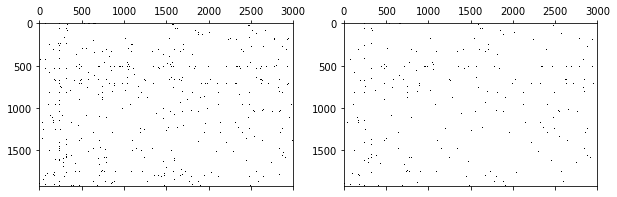

In [164]:
fig, ax = plt.subplots(figsize=(10, 20), nrows = 1, ncols = 2)
ax[0].spy(origA)
ax[1].spy(A_sp)

In [179]:
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import scipy.sparse as sp
import scipy.linalg as sl


def lowrank_SVD(input_matrix, approx=50):
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    sh = S.shape[0]
    S = np.diag(S)
    S[approx:] = 0
    S_ = np.zeros((sh, sh))
    S_ = S_ + S
    A_ = np.zeros((len(U), len(VT)))
    for i in range(K):
        A_ = U @ S_ @ VT
    return A_

def PMF(input_matrix, approx=50, iterations=30, learning_rate=.001, regularization_rate=.1):
    A = input_matrix
    Z = np.asarray(A > 0,dtype=np.int)
    A1d = np.ravel(A)
    mean = np.mean(A1d)
    #Remove DC term (mean), advice from
    #http://www.intelligentmining.com/2011/08/08/intro-to-matrix-factorization/
    A = A-mean
    K = approx
    R = itr = iterations
    l = learning_rate
    b = regularization_rate
    N = A.shape[0]
    M = A.shape[1]
    U = np.random.randn(N,K)
    V = np.random.randn(K,M)
    #PMF using gradient descent as per paper
    #Probabilistic Matrix Factorization
    #R. Salakhutdinov, A. Minh
    for r in range(R):
        for i in range(N):
            for j in range(M):
                if Z[i,j] > 0:
                    e = A[i,j] - np.dot(U[i,:],V[:,j])
                    U[i,:] = U[i,:] + l*(e*V[:,j] - b*U[i,:])
                    V[:,j] = V[:,j] + l*(e*U[i,:] - b*V[:,j])
    A_ = np.dot(U,V)
    return A_


def get_RMSE(A,A_):
    A1d = np.ravel(A)
    A_1d = np.ravel(A_)
    e = np.mean((A1d-A_1d)**2)
    return np.sqrt(e)

### Baseline 1 - SVD

Text(0.5, 1.0, 'RMSE for SVD')

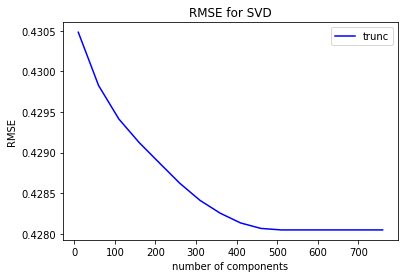

In [186]:
#Full matrix SVD, low rank approximation
approx = K = 100
iterations = I = 7

# A = X_full.copy()
# RMSE_full = []
# for K in range(10, 190, 20):
#     A_= lowrank_SVD(A, approx=K)
#     RMSE_full.append(get_RMSE(origA, A_))


#Sparse matrix, regular SVD example, low rank approximation
RMSE_sparse = []
for K in range(10, 810, 50):
    A_sp_tran = lowrank_SVD(A_sp, approx=K)
    RMSE_sparse.append(get_RMSE(origA, A_sp_tran))

fig, ax = plt.subplots(figsize = (6,4))
ax.plot(range(10, 810, 50), np.array(RMSE_sparse), color = 'blue', label = 'trunc')
ax.legend()
ax.set_xlabel('number of components')
ax.set_ylabel('RMSE')
ax.set_title('RMSE for SVD')

### Baseline 2 - PMF

Text(0.5, 1.0, 'RMSE for PMF')

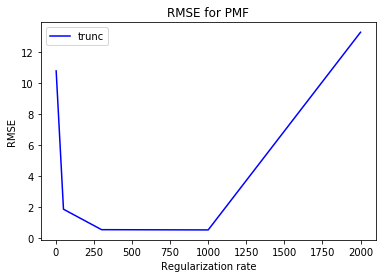

In [144]:
#Keeping learning rate constant for all PMF examples
l = 0.001
#Sparse matrix, gradient descent example
#Save RMSE as tuple of two values, (b,RMSE)
PMF_RMSE=[]
for b in [2., 50., 300., 1000., 2000]:
    A_=PMF(A_sp,approx=n_comp,
           iterations=I,
           regularization_rate=b,
           learning_rate=l)
    RMSE = get_RMSE(origA, A_)
    PMF_RMSE.append(RMSE)

fig, ax = plt.subplots(figsize = (6,4))
ax.plot([2., 50., 300., 1000., 2000], PMF_RMSE, color = 'blue', label = 'trunc')
ax.legend()
ax.set_xlabel('Regularization rate')
ax.set_ylabel('RMSE')
ax.set_title('RMSE for PMF')

fit n_components with the best regularization rate

Text(0.5, 1.0, 'RMSE for PMF')

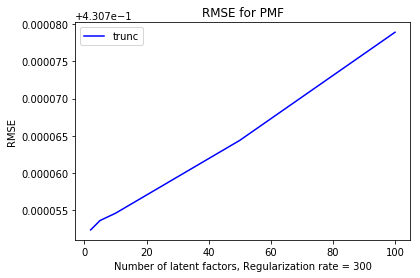

In [201]:
#Keeping learning rate constant for all PMF examples
l = 0.001
#Sparse matrix, gradient descent example
#Save RMSE as tuple of two values, (b,RMSE)
PMF_RMSE=[]
for b in [300]:
    for n_comp in [2, 5, 10, 50, 100]:
        print(n_comp)
        A_=PMF(A_sp,approx=n_comp,
               iterations=I,
               regularization_rate=b,
               learning_rate=l)
        RMSE = get_RMSE(origA, A_)
        PMF_RMSE.append(RMSE)

fig, ax = plt.subplots(figsize = (6,4))
ax.plot([2, 5, 10, 50, 100], PMF_RMSE, color = 'blue', label = 'trunc')
ax.legend()
ax.set_xlabel('Number of latent factors, Regularization rate = 300')
ax.set_ylabel('RMSE')
ax.set_title('RMSE for PMF')

----------------